<a href="https://colab.research.google.com/github/billumillu/Pose-Estimation-pytorch/blob/main/Pose_Estimation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my first project with Pose Estimation. I used [this repository](https://github.com/DavexPro/pytorch-pose-estimation) for reference. It's not exactly beginner-friendly. Took me a while to understand everything.

I've documented here what all I learnt, so this was not only useful for me to learn, but could also be a good tutorial if you are a beginner in Pose Estimation. If you have an easier implementation, do let me know!

Alright, los geht's!

### NOTE: Turn on Internet and GPU

In [1]:
import os
import cv2
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from utils import *

from torch.autograd import Variable

from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First let's download the pre-trained model.

In [2]:
import gdown

url = 'https://drive.google.com/u/0/uc?export=download&confirm=f_Ix&id=0B1asvDK18cu_MmY1ZkpaOUhhRHM'
model = 'coco_pose_iter_440000.pth.tar'
gdown.download(url, model, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=f_Ix&id=0B1asvDK18cu_MmY1ZkpaOUhhRHM
To: /content/coco_pose_iter_440000.pth.tar
209MB [00:01, 126MB/s] 


'coco_pose_iter_440000.pth.tar'

In [3]:
state_dict = torch.load('./coco_pose_iter_440000.pth.tar')['state_dict']   # getting the pre-trained model's parameters
# A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

model_pose = get_pose_model()   # building the model (see fn. defn. above). To see the architecture, see below cell.
model_pose.load_state_dict(state_dict)   # Loading the parameters (weights, biases) into the model.

model_pose.float()   # I'm not sure why this is used. No difference if you remove it.

PoseEstimation(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

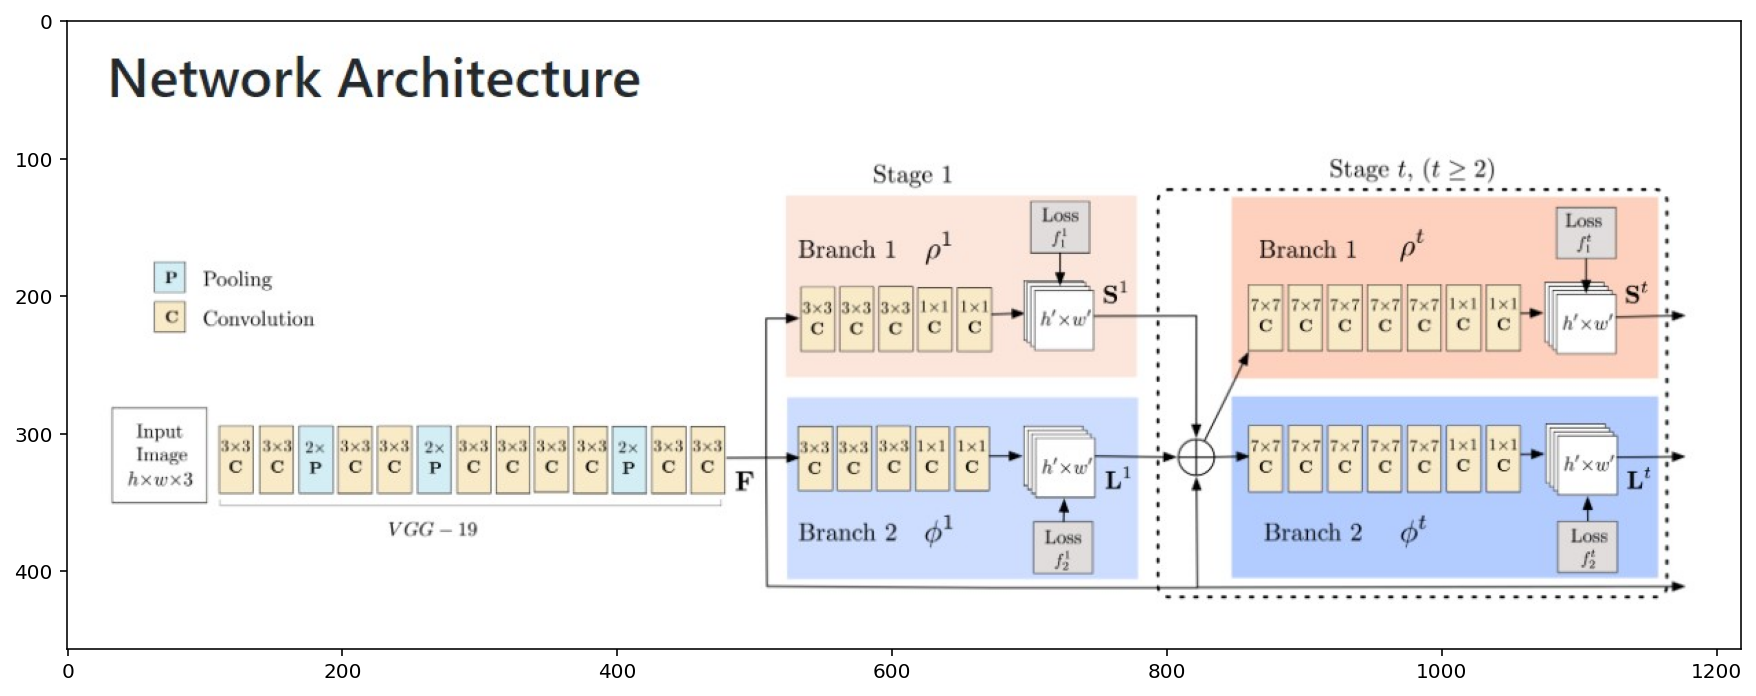

In [4]:
arch_image = '/content/images/architecture.jpg'
img_ori = cv2.imread(arch_image)
plt.figure(figsize=(15, 8))
plt.imshow(img_ori[...,::-1])

Notice, the first 10 layers are from VGG-19. But here instead of downloading the model and loading the layers from there, we simply hardcoaded it in get_pose_model()

In [5]:
# Run this to view the model's architecture
#model_pose.eval()

In [6]:
use_gpu = True

if use_gpu:
    model_pose.cuda()
    model_pose = torch.nn.DataParallel(model_pose, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

In [7]:
def estimate_pose(img_ori):
    
    # People might be at different scales in the image, perform inference at multiple scales to boost results
    scale_param = [0.5, 1.0, 1.5, 2.0]
    
    # Predict Heatmaps for approximate joint position
    # Use Part Affinity Fields (PAF's) as guidance to link joints to form skeleton
    # PAF's are just unit vectors along the limb encoding the direction of the limb
    # A dot product of possible joint connection will be high if actual limb else low
    
    paf_info, heatmap_info = get_paf_and_heatmap(model_pose, img_ori, scale_param)
    peaks = extract_heatmap_info(heatmap_info)
    sp_k, con_all = extract_paf_info(img_ori, paf_info, peaks)
    
    subsets, candidates = get_subsets(con_all, sp_k, peaks)
    subsets, img_points = draw_key_point(subsets, peaks, img_ori)
    
    # After predicting Heatmaps and PAF's, proceeed to link joints correctly
    img_canvas = link_key_point(img_points, candidates, subsets)
    
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_points[...,::-1])
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_canvas[...,::-1])

torch.Size([1, 38, 23, 12])
torch.Size([1, 19, 23, 12])
torch.Size([1, 38, 46, 24])
torch.Size([1, 19, 46, 24])
torch.Size([1, 38, 69, 36])
torch.Size([1, 19, 69, 36])
torch.Size([1, 38, 92, 48])
torch.Size([1, 19, 92, 48])


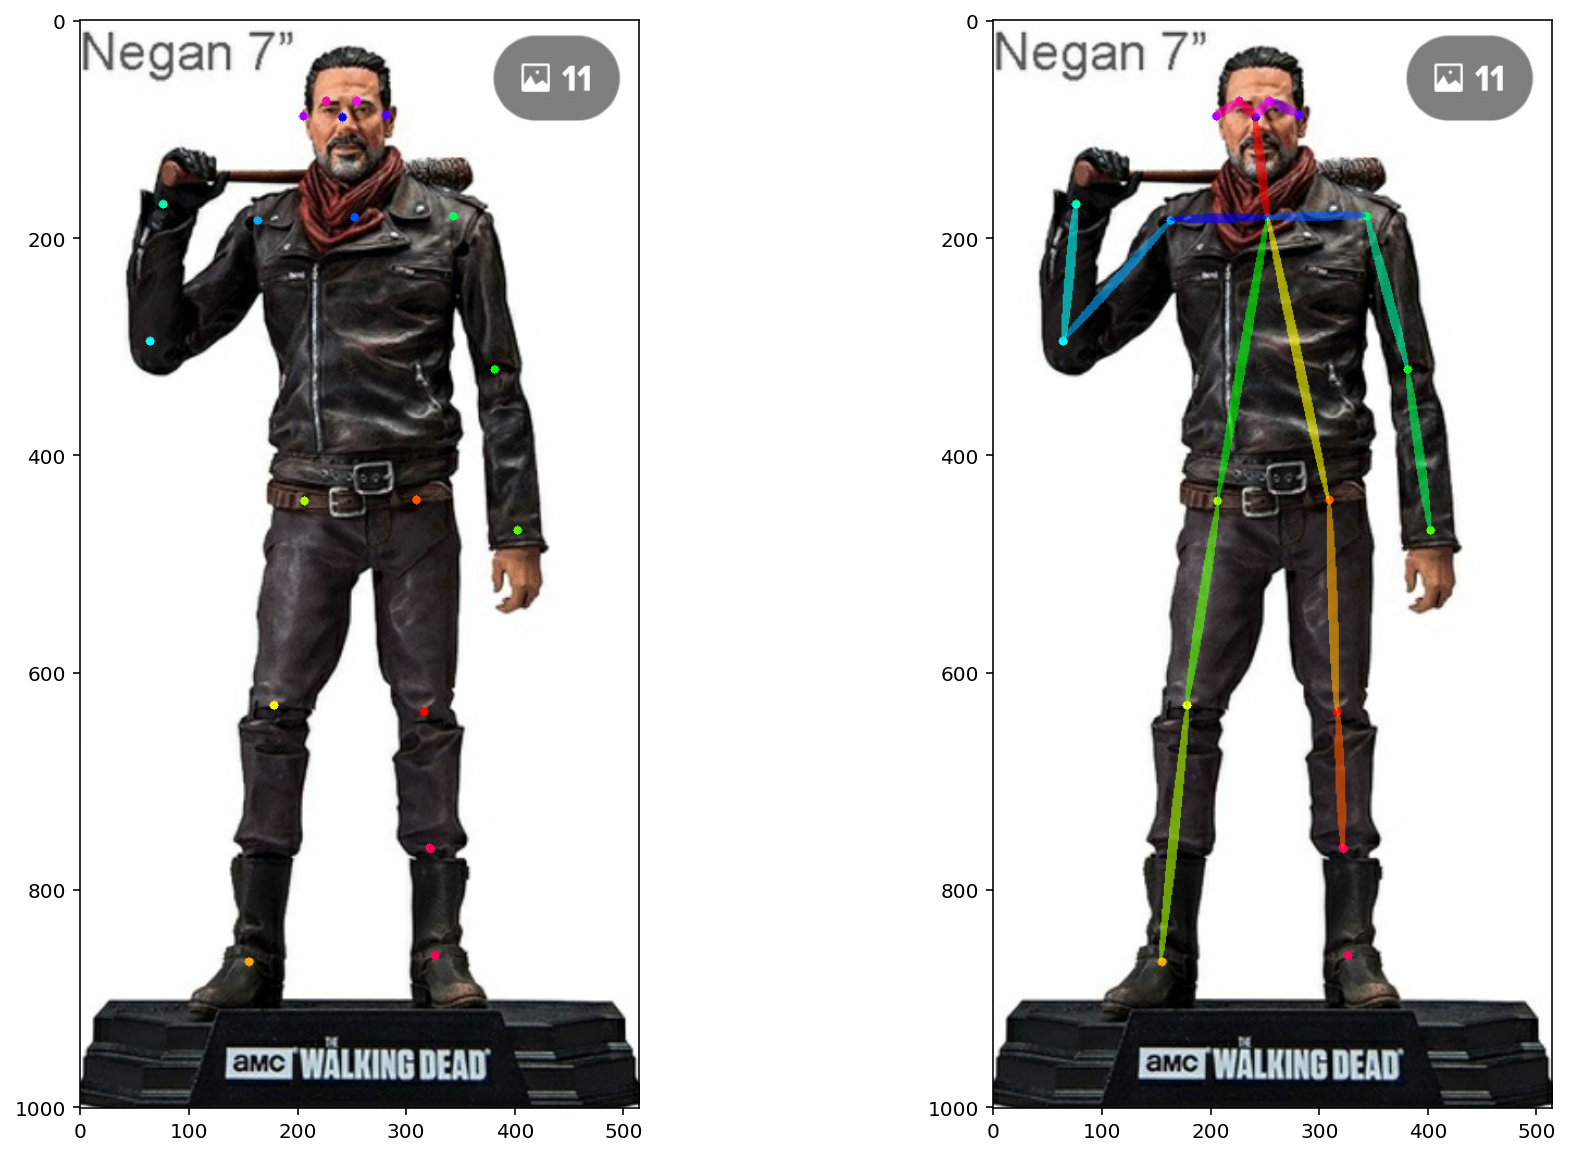

In [13]:
test_image = '/content/images/Screenshot_20200421-155554_Wishh.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

torch.Size([1, 38, 23, 27])
torch.Size([1, 19, 23, 27])
torch.Size([1, 38, 46, 54])
torch.Size([1, 19, 46, 54])
torch.Size([1, 38, 69, 81])
torch.Size([1, 19, 69, 81])
torch.Size([1, 38, 92, 107])
torch.Size([1, 19, 92, 107])


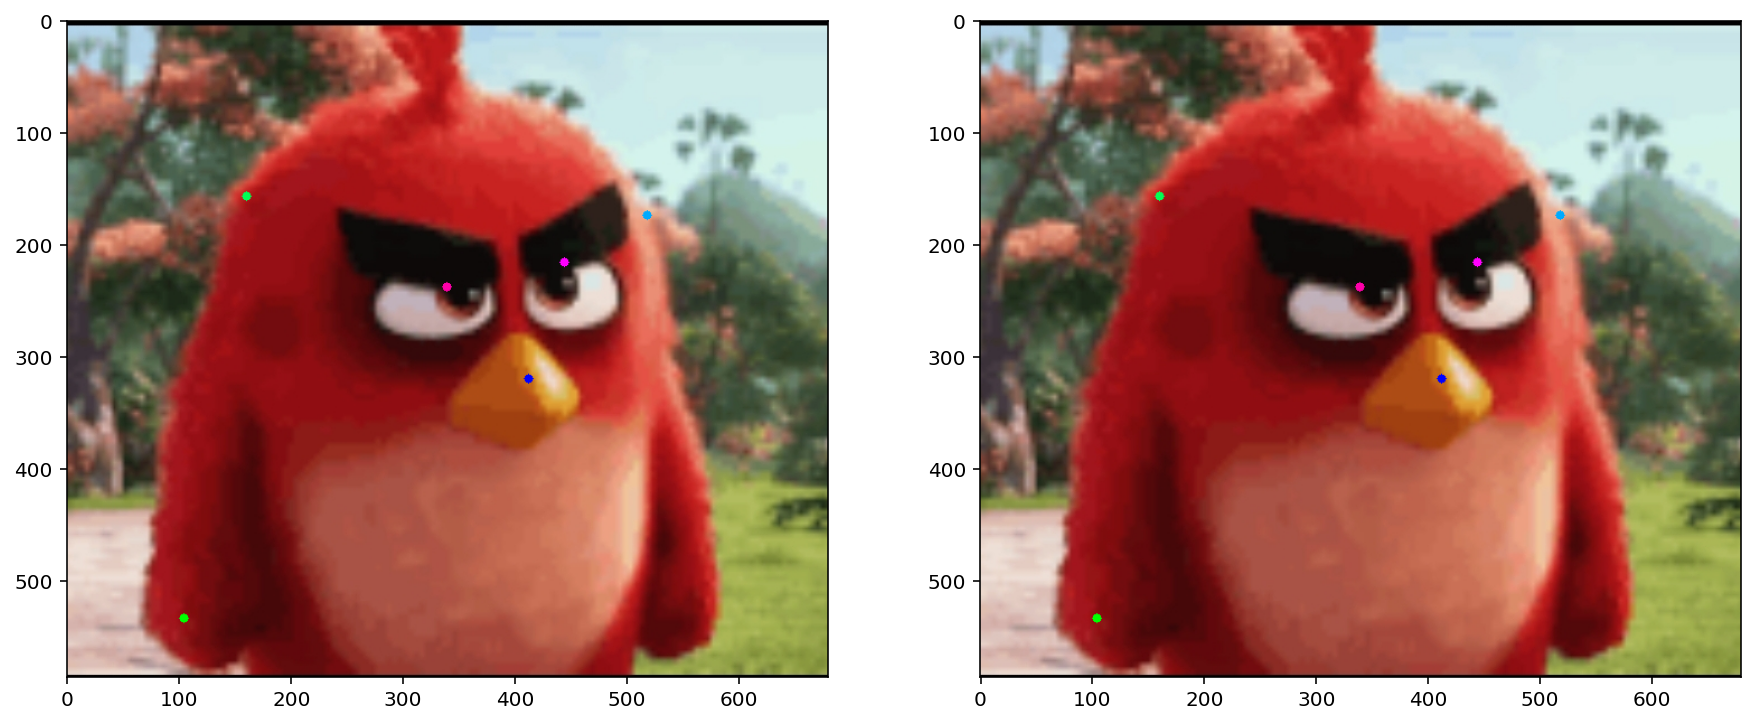

In [14]:
test_image = '/content/images/Screenshot_20200623-062005_WhatsApp.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

Detecting 6 features...

torch.Size([1, 38, 23, 14])
torch.Size([1, 19, 23, 14])
torch.Size([1, 38, 46, 27])
torch.Size([1, 19, 46, 27])
torch.Size([1, 38, 69, 40])
torch.Size([1, 19, 69, 40])
torch.Size([1, 38, 92, 54])
torch.Size([1, 19, 92, 54])


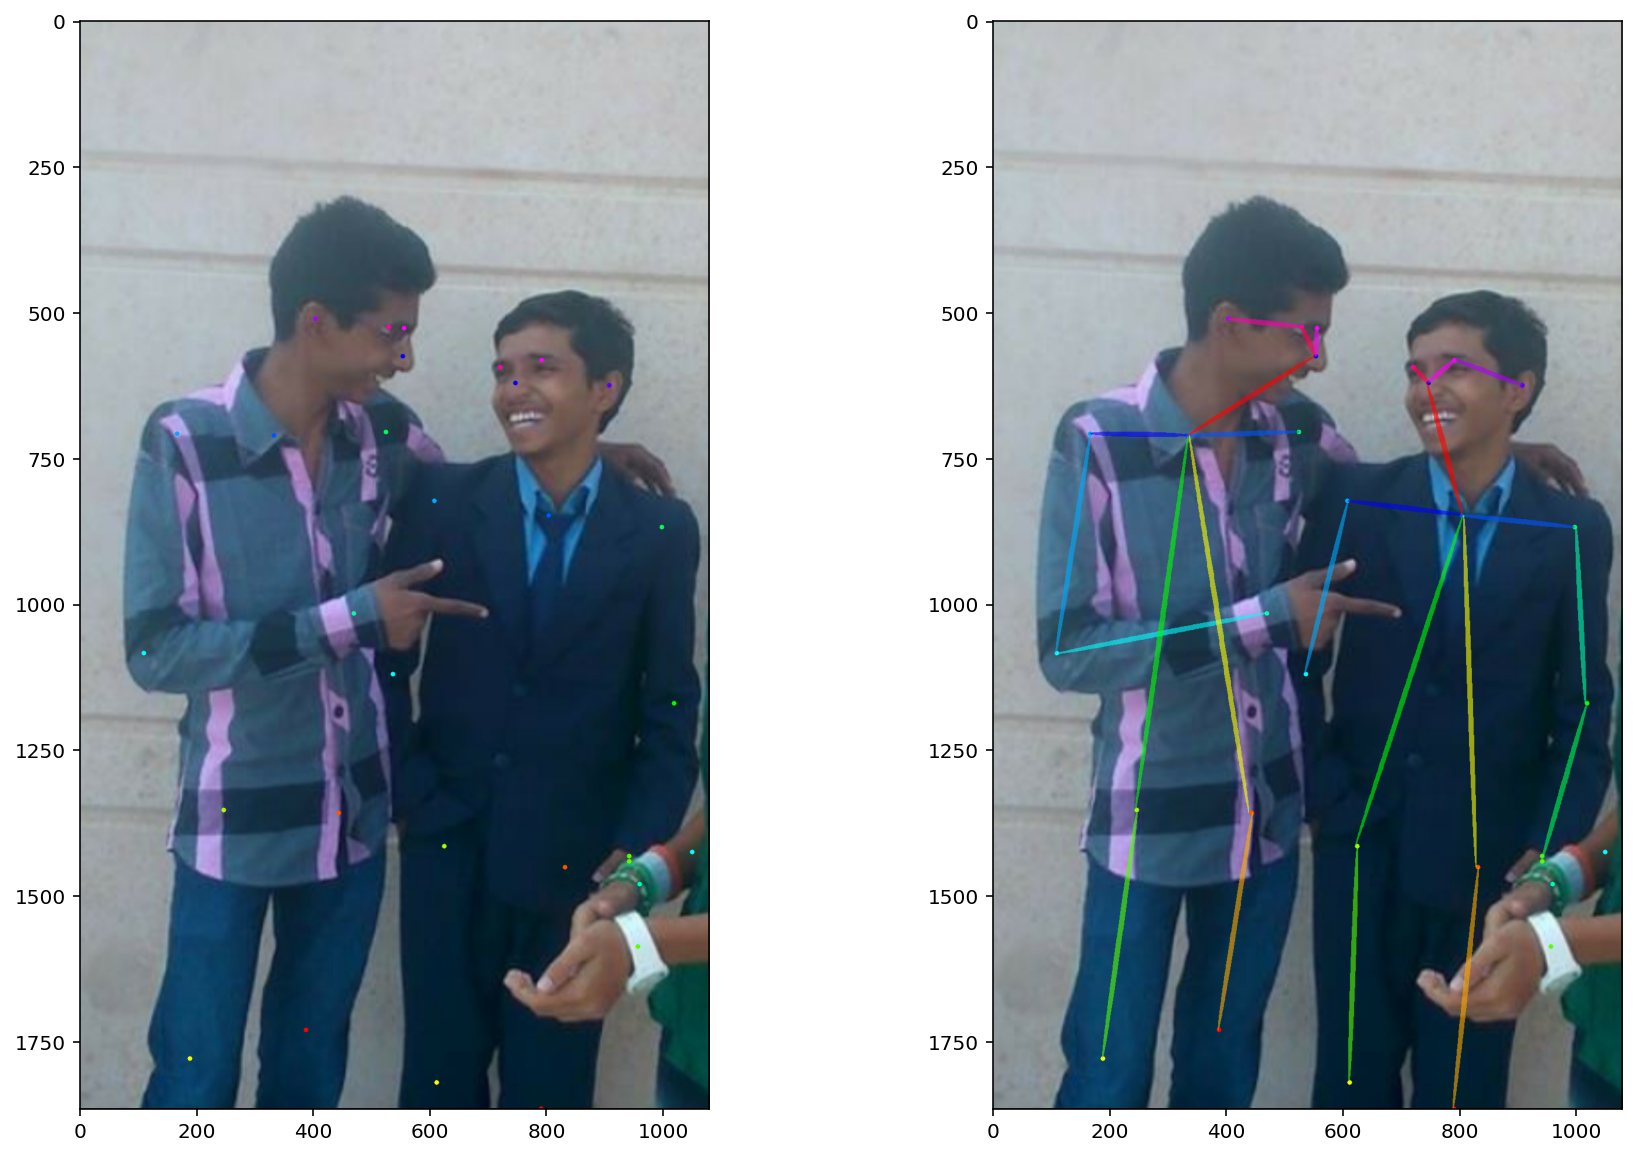

In [10]:
test_image = '/content/images/Screenshot_20200322-200133_Files.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

torch.Size([1, 38, 23, 50])
torch.Size([1, 19, 23, 50])
torch.Size([1, 38, 46, 100])
torch.Size([1, 19, 46, 100])
torch.Size([1, 38, 69, 150])
torch.Size([1, 19, 69, 150])
torch.Size([1, 38, 92, 200])
torch.Size([1, 19, 92, 200])


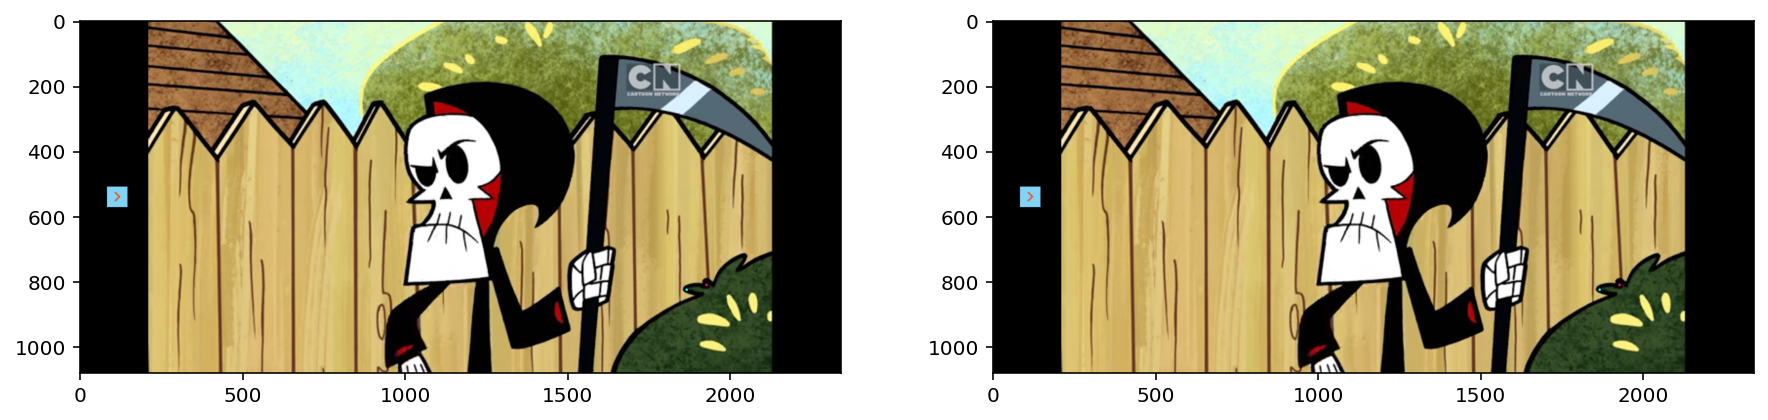

In [11]:
test_image = '/content/images/Screenshot_20200526-200305_YouTube.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

Nooooo nothing for Grim!

torch.Size([1, 38, 23, 46])
torch.Size([1, 19, 23, 46])
torch.Size([1, 38, 46, 92])
torch.Size([1, 19, 46, 92])
torch.Size([1, 38, 69, 138])
torch.Size([1, 19, 69, 138])
torch.Size([1, 38, 92, 184])
torch.Size([1, 19, 92, 184])


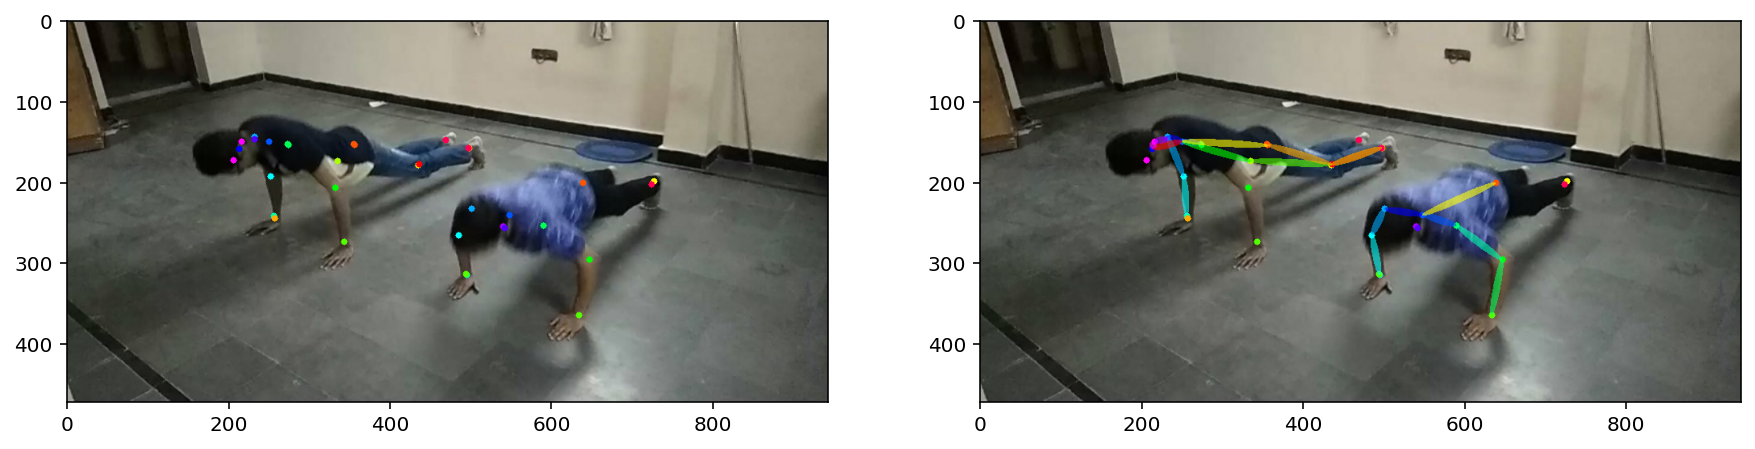

In [12]:
test_image = '/content/images/20200317_114104.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

Done. This is a very simple project. We simply used a pre-trained model. It was trained on the COCO dataset (250,000 people with keypoints - 42.7GB!)

I have more plans with this later. I want to fine-tune it for a particular use-case. Gotta learn that!

# Citation

@inproceedings{cao2017realtime,

  author = {Zhe Cao and Tomas Simon and Shih-En Wei and Yaser Sheikh},
  
  booktitle = {CVPR},
  
  title = {Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields},
  
  year = {2017}
 
 }